# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/toxiccomments_train.csv', my_random_seed=70)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 6383, 'TN': 59505, 'FP': 55157, 'FN': 6611, 'Accuracy': 0.5161371185059849, 'Precision': 0.10372115697107573, 'Recall': 0.49122672002462675, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12898, 'TN': 114549, 'FP': 113, 'FN': 96, 'Accuracy': 0.9983627874913831, 'Precision': 0.9913150411190531, 'Recall': 0.9926119747575805, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12923, 'TN': 114594, 'FP': 68, 'FN': 71, 'Accuracy': 0.9989111361784797, 'Precision': 0.9947656069586637, 'Recall': 0.9945359396644605, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12721, 'TN': 103334, 'FP': 11328, 'FN': 273, 'Accuracy': 0.9091229554427523, 'Precision': 0.5289617031893218, 'Recall': 0.9789903032168693, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12871, 'TN': 114490, 'FP': 172, 'FN': 123, 'Accuracy': 0.9976891019615216, 'Precision': 0.9868128498044928, 'Recall': 0.99053409265815, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 10951, 'TN': 114474, 'FP': 188, 'FN': 2043, 'Accuracy': 0.982523343986965, 'Precision': 0.9831223628691983, 'Recall': 0.8427735878097583, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/yujunjiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 12994, 'Neg': 114662, 'TP': 0, 'TN': 114662, 'FP': 0, 'FN': 12994, 'Accuracy': 0.8982108165695306, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/yujunjiang/Desktop/Machine Learning/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

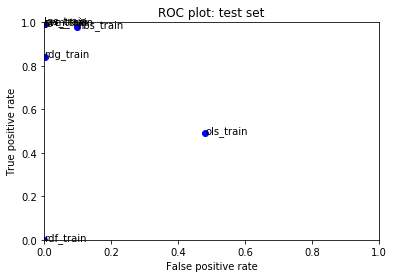

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [13]:
ols_predictions = ols.predict(X_train)

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
1
Asperger's Syndrome 

Do you really think that Asperger's is in some way a reason that someone shouldn't be editing?
* * * * * * * * * 
113
" I removed the part about false skepticism because it is unprovable and inhereintly doesn't go together. False being the opposite of truth, and skepticism believeing nothing to be certain. To be a false skeptic is impossible to prove and is not a view point but a chance for people to oppose halocaust deniers and such in a biased way on the wiki. I believe that most likely the halocause for example happened, but I am not going to say it is ""false skepticism"" nor are the ""sources"" any more reliable or proving anything. So you know how to report better, have better contacts, and tend to have a majority(or enough active members) to back your agenda. Then martyr me and get it over with. It is better to delete it since I legitamately believe it to be unsalvagable and completly opinionated to the point that is pushes a 

3066
. Where did you read she only registered her Portuguese birth certificate at the same time  she got her Portuguese passport?
* * * * * * * * * 
3082
"own personal copy but I think that the RSA constitution specifies the country's official langs by name. I'll look for it - sometime. If you understood properly what I meant by ""7 vowels"" (mopane) then you'd immediately see that  ""seSwati"" can't be a valid Nguni word. Shall I elaborate"
* * * * * * * * * 
3090
Weak support'' a merge, I tend to agree that butterfly cake is a non-notable variant. Could be persuaded otherwise if sourcing was found to suggest otherwise.  (talk ·''' contribs)
* * * * * * * * * 
3124
Afraid I don't know what a furphy is, but one link (http://sti.bmjjournals.com/cgi/repnt/79/1/65.pdf) was a typo as far as I can tell (compare with the corrected South Korea URL: http://sti.bmjjournals.com/cgi/reprint/79/1/65.pdf  two characters are missing). Either way, the links were wrong. I'll try to remember where I've

5799
Barnstar

Working Man's Barnstar given to  for exceptional diligence in weeding out typos and grammatical errors - and more! TOP work!  23:44, Mar 6, 2005 (UTC)
* * * * * * * * * 
5858
Certainly relevant.
* * * * * * * * * 
5877
Details
 Thanks for your help with editing. I hope you didn't mind that I took down a lot of your work suggesting Nawab was overseeing the project at KRL. I don't think  and others would have let it stand without references. 

Also, I found it intriguing how you changed his qualification from first division BSc in Electrical Engineering in 1948 to a BSc in Physics and Chemistry in 1947. It is hard to imagine that the Pakistan Army, Bhutto and Ghulam Ishaq Khan etc would have promoted an EME officer to the rank of major general in 1975 and put him in such a technical position as you are suggesting, without at least a proper degree in engineering. Don't you think?
* * * * * * * * * 
5908
You talked and You removed his leanings towards Sufism.There is nothing

8416
In Transformers the Game(2007) Skydive is an Autobot Cybertronian Fighter Jet that is not playable.( )
* * * * * * * * * 
8596
"

This is well cited and shouldn’t be censored. Just saying.  Thanks for the welcome.

Choudary has said that anyone becoming intoxicated by alcohol should be given 40 lashes in public. He claimed alcohol was ""the root of all evil” and that ""Islam additionally imposes 40 lashes in public for deliberate intoxication, followed by 80 lashes in public if repeated for a second time.”."
* * * * * * * * * 
8624
"

 If you continue to vandalize the ""defensive gun use"" page, you will be blocked from Wikipedia 

Warning! Please use your head. There are 1.2 million incidents of violent crime in the US yearly. Please do not insert made up facts without reference into articles, claiming ""33 million defensive gun uses."" The number of legitimate defensive gun uses in the U.S cannot exceed the total number of crimes, friend."
* * * * * * * * * 
8694
And, as an exam

11019
There was no consensus to not reopen the naming debate, the move request was opened as 3am central European time when the Mega Drive world was asleep and closed at 4am, the only people who got a chance to vote were Americans and they voted from a bias nationalist viewpoint instead of on the merits of the changes, if the poll were allowed to run more than an hour a judgement could then be made on weather or not consensus was achieved but noting can be inferred from a 1 hour poll
* * * * * * * * * 
11021
"
Stop this outrages accusation! Your accusation as “nobody but you supported and without explaining the reasons for them on talk pages”  is ends only looking on these different edits   . Different contributors suggested to stop your one sided actions  as well as  it is clear disruption of wikipedia  and as you say if you continue such behavior you may find your behavior reported and yourself blocked. Removal of valid information  and classify as POV pushing even then sources are p

13757
"

 Holocaust denial 

If there is no actual proof that Jeff Rense advocates holocaust denial, then the category ""Holocaust deniers"" should be removed."
* * * * * * * * * 
13838
It was me. 19:35, August 12 2006 (UTC) Example 19:35, August 12 2006 (UTC)
* * * * * * * * * 
13860
"::My darling C,
First off, thanks a million for doing the merge – been out all day, couldn't do it myself despite my intentions.
Yup, I saw you were working on t'article so I decided not to stick my bloody nose into it. While you'are at it, be careful w/ word order here: ""A small statue of the Virgin and child is seen behind the main figures, positioned in a choir screen, between two lit candles"". If you put the bold text at the end, it may be confusing 'cause it could be interpreted as if the main figures were the ones in the choir screen, which obvs is not the case. Plus, it isn't quite clear what is between the lit candles (the choir or the statue) and, IMHO, ""positioned"" makes the prose a trifle 

16434
Brews, I see that you are now asking the exact same question. Right now I don't know the answer.
* * * * * * * * * 
16473
Your way is overly convoluted, difficult to read, and way too loosey goosey on the one away list.  Please limit one aways to guys who are at least semi-active.  Santino is long retired.  The way things were was fine as is with no complaints...if it ain't broke, don't fix it.   When you have 2 editors telling you to back off, then it's kinda time to fold 'em.  (talk)
* * * * * * * * * 
16504
"

 The community is requesting restoration of article creation to unregistered editors  

This has been discussed in various places and consensus has been achieved in each.

The relevant parts of the latest discussion this week at User talk:Jimbo Wales are as follows:

When they search a topic and there's no article let the comment be

You may create the page ""X"" but consider checking the search result below to see whether the topic is already covered ...

The proposal t

18967
Ageism
For the sake of sparing the ageism talk page, I want to address an ongoing issue I'm have with your edit style. I find the way you posted your disagreement with the ER quote to be argumentative, combative and completely anti-collaborative. Is there a more productive way you can frame your apparently contemptuous disdain for the youth-related articles you continuously edit this way? –  (¡!¡!¡!¡)
* * * * * * * * * 
19003
Trojan War 

Hey man, I saw that you were the lead coordinator of the Military History Project so I have a question to ask you if you don't mind. Does the Trojan War fall under our Project's Jurisdiction? Thanks!
* * * * * * * * * 
19034
Stop telling me what to and not to do. This isn't your personal playground. I NEVER said tallaarmeniantale and Balakian are the same - I compared them. I SAID Balakian is ARMENIAN therefore he is biased just like tallarmeniantale is TURKISh and biased. I know you understand so give up the innocent act. I reported you as well

Every reliable secondary source gives the last name as Dandridge.
* * * * * * * * * 
21421
Arma 2/Arma 2 Operation Arrowhead 

As I understand it Bohemia hasn´t released any sales numbers for Arma 2 and it´s standalone expansion,Operation Arrowhead,but considering that on the official site of the DayZ mod there are over 1.3 Million unique legal users,both Arma 2 and Arma 2 OA have sold at least 1.3M copies each(obviously they sold more but that´s the only metric available),so I suppose both of them can be added to the list,either by listing each at 1.3M or,just like Guild Wars,putting both together at 2.6 Millions.

Thanks.
* * * * * * * * * 
21439
block and give me one more chance. Thank you.}}
* * * * * * * * * 
21464
ACS
you are either another blackjack sock or as deluded as John Leach a lonely unemployed man with disability issues living in north Yorks. And I am an ACS member, have appeared in Wisden and was, until I resigned, the editor of a respected cricket journal. You on the o

23613
Well you ask good questions.  But you don't seem to realize that Greece was far from neutral:  it was squarely on the side of the British.  Mind you, I am glad they fought for the Allies, but they paid a heavy price, both during and especially after the war, when I believe they suffered more casualties than suffered by the USA in the entire war.  As for Calvocoressi et al, the text speaks for itself.  I guess one synthesis is as follows:  Greece could have, like I believe Hácha's government in Czechoslovakia in 1939, authorized capitulation to the Germans, and avoided the bloodshed of the Athens occupation and more so the Battle of Crete.  But this is alternative history.  And besides the Greek resistance was a moral boost for the allies, even if you don't believe that (as most neutral historians do not) it delayed much, if at all, German's invasion of Russia.
* * * * * * * * * 
23719
Welcome, and thank you for experimenting with  Wikipedia! Your test worked, and thank you for re

25805
its MY TALK PAGE . HELLO CAN YOU NOT SEE THAT. I AM SHELBY YOUNG AND I WANT MY NAME OFF THIS WEBSITE AND PER JIM WALES I CAN REMOVE BOTH THE IP ADDRESS AND MY TALK PAGE SO GTFO.
* * * * * * * * * 
25831
Oh now I see. Thanks Erick,
* * * * * * * * * 
25880
getting images released, will not happen. Due to copyright complexity its not possible to release those images freely. Because wikipedia only permission is not enough, wikipedia only images are still non-free. the current usage of non-free content is almost purely cosmetic and is why they where removed. those images fail part three of the non-free media policy. Honestly it doesnt matter what the owners of the game say, they have zero control over the content of the article. βcommand
* * * * * * * * * 
25985
"

According to Simon Schama's book The Power of Art, Guernica was painted in response to an article that Picaso saw in an French newspaper. The first line suggests that he was already working on the project when the bombs fe

28186
It appears that you are not helping me to post something that is informative and consistent with Wiki policies. Instead, you delete all my effort to put a factual statement and reference.  I am not a regular Wiki user and need help doing this correctly.
* * * * * * * * * 
28253
"
Certainly. Yes change to the research section wording occured back in 2011  and was not make by you.  (talk · contribs · email) "
* * * * * * * * * 
28284
:Willington Nameplate, Inc
A tag has been placed on Willington Nameplate, Inc, requesting that it be speedily deleted from Wikipedia. This has been done under the criteria for speedy deletion, because the article seems to be blatant advertising that only promotes a company, product, group, service or person and would need to be fundamentally rewritten in order to become an encyclopedia article. Please read the general criteria for speedy deletion, particularly item 11, as well as the guidelines on spam. 

If you can indicate why the subject of this art

30408
I am impressed that so many editors have noted the poor quality of this page, and yet none has deigned to add to the article.  I would appreciate some help, rather than being accused of bias for trying to start working on a subject that deserves to be treated as a full fledged article.  I am not an expert in this area, but I feel that there is enough knowledge in the wikipedia community to improve this article to a higher standard than I am personally capable of.  I must also apologize for being distracted by other issues on wikipedia.  Nonetheless, I think this article is valuable, even though it deserves massive improvement.
* * * * * * * * * 
30476
Why did you remove my contribution to the Ohio State University page? 

Why did you delete my contribution to the OSU Page on 1OSUNut. It was under the notable alumni section and absolutely everything was true according to over 2000 University of Michigan Alumni on hailvictors.com.  Will you please repost my comments? If not why?
* 

32908
There is currently a mediation case involving Jacrosse's edits to the Neoconservatism article.  You might check that out and talk with the head of the mediation people,
* * * * * * * * * 
33001
"

 Blocked 

I am currently blocked for 24 hours. Any question, issues, etc that would somehow require my unblocking should be addressed to  Talk| "
* * * * * * * * * 
33009
"

 Please do not vandalize pages, as you did with this edit to Les Paul. If you continue to do so, you will be blocked from editing.    "
* * * * * * * * * 
33011
What I had uploaded to create the article was fit for Wikipedia.  I was in the middle of revising further material when I had to do a Hang On because of your precipitate Speedy Delete.  I believed that notability was clear from the fact that Perisic was in a position of senior authority while Milan Lukic perpetrtated the Visegrad Massacres - linked in the article to their description as among the worst examples of man's inhumanity to man.
* * * * * * * * * 

35421
"
Information is placed online effortlessly compared to placing information in print, which is why I said what I did.  Sounds like the review will suffice, based on your explanation of the publication's history.  Like I said, I focused on removing contributions related to Lawrence Person since it seemed to me that there was a conflict of interest going on.  As an objective party to this, you can restore the review as you see fit. ) — (talk • contrib) "
* * * * * * * * * 
35496
Block Appeal 

 

We were in the middle of a discussing regarding my block when I was blocked. Please unblock my account since I have promised not to do personal attacks again.
* * * * * * * * * 
35505
"

Makes sense.  We often have refernces to ""critics of"" etc. So properly attributed as opinion, we can consider this new bit of info. Really I'm thinking we need to little more than a mention that in the opinion of Krugman, Reagan deregulation planted one of the seeds for the current economic challenges.  

37895
Thank you for being the first person to tell me what I can do and not telling me I'm Grammer.
* * * * * * * * * 
38029
Let me spell it out for you. The content of the page you are using as an excuse to put up the speedy deletion tag is a quote from a blog that belongs to me. I am the owner of the blog. What evidence do you need exactly? You have also accused me of originating the article here when the author is someone else and two other people have been accused of sock-puppetry on no evidence. The instructions for the tag say that someone who has originated the article may remove it. That is what I did because I am not the article's originator
* * * * * * * * * 
38123
"I suggest that there be a ""Lincoln High School (Tallahassee, FL)"" Page and then a separate ""Historic Lincoln High School (Tallahassee, FL)"" Page.

"
* * * * * * * * * 
38128
"

= User:Crusio 
 
It appears that friends of the user Crusio are not required to meet the wiki requirements, on notable people. For exa

40556
The link had to do with a complaint in relation to the name and location of the person at issue.  He did not want his name, or at least some of his information publicly available, and that is the kind of issue that WP takes seriously as it could have legal implications for WP.  BLP allows any editor to remove such material immediately. I hope that helps clear it up.
* * * * * * * * * 
40626
Does anyone have any logical reason it should not be moved, or should we go ahead and move it 142.59.249.84
* * * * * * * * * 
40697
, where is this gedankexperiment coming from anyway? What is its relevance? Is there any such experiment that has ben reported in a peer refereed journal? If not, why is it included?
* * * * * * * * * 
40805
Blocked 

Since you did not listen to the various warnings above, and continued with the creation of disruptive fork articles, I have blocked you for 24 hours. When your block expires, please consider what you are doing here and how you can contribute more co

43141
It now reads like a fan magazine. Cut down on the trivia please.
* * * * * * * * * 
43174
No Personal Attacks 

I appologized to the girl for my actions and she forgave me. Disregard the previous post above and let me continue with my edits like I always do.
* * * * * * * * * 
43346
"Welcome

Hello and welcome to Wikipedia!  We appreciate encyclopedic contributions, but some of your recent edits do not conform to our policies.  For more information on this, see Wikipedia's policies on vandalism and limits on acceptable additions. If you'd like to experiment with the wiki's syntax, please do so in the ""sandbox"" rather than in articles.

If you still have questions, there is a new contributor's help page, or you can write {{helpme}} below this message along with a question and someone will be along to answer it shortly.  You may also find the following pages useful for a general introduction to Wikipedia.
The five pillars of Wikipedia
Help pages
Tutorial
I hope you enjoy editing 

45642
Forth support from me. These attacks lead to edit warring. Something we don't need.
* * * * * * * * * 
45670
You have left me no choice. Wikipedia is a group of fellow editors. You will be banned according to your actions, not your status.
* * * * * * * * * 
45711
"

Randalmann, just look at the title. ""Dubious claims by Dapi89"", so he is questioning me, not the source. He keeps saying the burden of proof is on me, yet I have always cited my work on wikipedia. My tone is indicative of someone who is tired of dealing with a problematic editor who has insulted me and others over a consistent period of time. 
I have always answered his questions, yet he persists. The problem with ""quoting"" is that Caldwell likes to provide Order of table tables for claims and graphs for strength returns. I can add that if you like?   "
* * * * * * * * * 
45732
"=Remove the Tricolour from this article===
The Tricolour is not a symbol of Northern Ireland, so why is it in this section? It seems tha

48033
Hi, Scottywong, I already said on Boing's page, I am making an arbitration request. Before i could do it, Qwyrxian asked for a user block (Qwyrxian again!!). Now I find I cannot request for arbitration. I request an unblock only on arbitration page so i can go ahead and file a report there. Qwyrxian's contention that Hari7478 and i did not resume discussion on talk page makes no sense. It seems apparent Qwyrxian neither read content on the Iyengar talk page nor the ANI complaint (though had requested Qwyrxian to read before asking me to paste the same stuff all over again). The tactic appears to be like this  allow Hari7478 to evade answering, then ask me to paste the same stuff on talk page all over again until i give up. And sadly, no admin wants to take a call on the content or check the sources despite typing out the full page of each source misquoted by Hari7478. In such case, there is not choice but to apply for arbitration. So please allow for arbitration. Thanks.  Mayasut

50404
How to edit big topics like Eminem? 

How do you?

(  )
* * * * * * * * * 
50523
, 2 November 2006 (UTC)

alright fine. apology accepted. i gotta work on my style and communication skills.  19:40
* * * * * * * * * 
50540
"

 Baruch College 

Thanks for your edits to Baruch College, I just thought I'd let you know a couple of tips. Normally for section headers (the things the look like ==Section== on the editting page) are not bolded (i.e., '''bold text''') nor are the second and subsequent letters capitalized unless they are proper nouns (e.g., so ""Academic Centers"" should read ""Academic centers""). Hope this helps in the future!

 "
* * * * * * * * * 
50574
Why This Can Not Become a Articule?? 

 Help me write the articule
* * * * * * * * * 
50577
By including speech marks, you cut out nearly 1000 valid results by making your seach needlessly specific. I could point out many search results that back this up, on-topic websites that were cut out because of your rather silly (an

Thank you. Your suggestions are good ones, as I said; we'll see what Drove thinks. I didn't know it got noticed someplace. This and Hush were my first 2 articles of any real note. I just write to improve the prose where I can, correct grammar, do housekeeping. I don't originate articles (at least not so far). I've actually spent what feels like lifetimes shortening and tightening up plot sections all over this place, but it's a losing battle for most films, as fans will just not leave them alone. I understand the impulse'this bit is so important to me it just has to be in there'; explaining why it can't be gets very old very quickly. But I do still try. Glad to see someone else fighting the good fight.TEHodson
* * * * * * * * * 
52811
Females joining ACF 

I have made an entry for the Girls Venture Corps which was formed in the early 1940's GVC units were often attached to ACF and ATC units, does anyone know when the ACF started admitting girls directly? I think there should be some me

55097
vandalism
Hi Spute. I began trying to police this ?#!@, but gave up because it’s aggravating and time consuming, especially for someone still figuring out Wikipedia. But here’s what I got. I suspect these are all the same person, and there’s possibly more:
User talk:Theradioguy,
User talk:88.108.57.57,
User talk:88.110.161.3,
User talk:88.109.218.223,
User talk:88.108.58.129,
User talk:74.231.219.98,
User talk:88.108.49.184,
User talk:88.108.51.238,
User talk:88.111.14.2,
User talk:88.108.59.49,
User talk:88.108.52.34,
User talk:88.108.51.191,
User talk:88.108.63.44,
User talk:88.108.63.88

The following are most of the pages that are vandalized is the same way, i.e., adding in bizarre/inappropriate gender references. Most are fairly trivial articles, i.e., recent fashion trends, but some are big and sensitive topics, like rape. In the past, comments people made on talk pages were erased, which is a big faux pas on Wiki.
Boyfriend,
Hoodie,
Brassiere,
Violence against women,
Breas

57611
This message is regarding the page Pgufs. Thanks for experimenting with Wikipedia.  Your test worked, and has been removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing.  Thanks.  | talk
* * * * * * * * * 
57703
There is no need for personal attacks. Fennessy is known for disruptive edit warring and should not be attacking other users for disagreeing with him.
* * * * * * * * * 
57718
Yes I did that too
* * * * * * * * * 
57778
The pov in inherently unencyclopedic.
* * * * * * * * * 
57812
"

Uh accused by who? I gave my real name. What did I do that was uncivil? Apparently those people can call me every name in the book, accuse me of being other people, and vandalize entries, yet I am blocked for being uncivil? I stopped eidting when I was told to stop.
Explain how you arrived to the conclusion I was some kind of sockpuppet. Is this how you treat all new users that don't want to see 

60296
"

From the prod, ""You may remove this message if you improve the article or otherwise object to deletion for any reason. However please explain why you object to the deletion, either in your edit summary or on the talk page. If this template is removed, it should not be replaced.""  The prod was removed with a reason and it should not have been replaced even if there was not a reason given.   "
* * * * * * * * * 
60392
Every documentary is without error? Interesting. ~
* * * * * * * * * 
60433
I know that MadonnaTribe is a fansite. Nonetheless, almost all of their exclusives have later been confirmed by official sources, such as the full setlists of Madonna's two latest tours and titles of 5 songs off Madonna's Hard Candy album. As of now, their news item on the tracklisting is accessable from their front page, as a top news story.
However, as I've already commented, the tracklisting hasn't been officially confirmed, and therefore, I agree that it shouldn't be included in the a

62822
IRS notice 

Hello there,
this is the IRS. You owe us $19,000 in unpaid taxes.

Kristina Gonzalez,
Inland Revenue Service
http://www.irs.gov.

2602:FFEA:1:131:0:0:0:D348
* * * * * * * * * 
62834
"

 hello 

I left a rather too full reply at my talk page. I was taking a break while things cooled down. I was editing under IP – not as a sock but to avoid the flak – but the address range has been blocked so unfortunately I have to be myself again.

Thank you for your kind comments. I have been editing in my gnomesome way – fiddly bits of spelling and stuff like that – under IP. ""Yet man is surely born to trouble as the sparks fly upward"". Job 5:7 apparently. I am not very Christian (well that is Jewish anyway) but you can't beat the Bible for a decent murder, beats Agatha Christie any day of the week (and twice on Sundays).   "
* * * * * * * * * 
62845
" (UTC)

Please change ""irish-born British"" to ""irish"" or to ""irish who worked mainly in London"" because of the following; Th

65194
Sorry must of missed that one. Thanks for your review, I had asked another editor to do a quick c/e of the composition section. Thanks,
* * * * * * * * * 
65213
But  just won't stop destroying several entertainment company articles. All he does is remove useful/accurate information, erasing owner/parent company lists in infoboxes, butchering the formatting, and renaming sections to used company names, so HE'S the one who's a vandal. Why don't you just block him and revert his edits before it's too late?  68.98.224.182
* * * * * * * * * 
65250
"{| class=""messagebox standard-talk""
|-
|
|This discussion page may contain comments better considered as trolling, posted in order to prompt irate replies that can then be even further ridiculed, in turn. Before you post any reply, consider how you might minimize the effects of trollish comments. Simply ignoring certain comments may be the best option.
|}

Example of McNeight's 'trolling' is shocking:

Wikipedia is a community. The focus 

67690
I've restored the links to the specific subject-area year articles, since such linking is considered appropriate when it offers relevant informationand the contextual cultural field within which a film or play was received is clearly a relevant context. The notion that a year link within a sentence about a film that goes to that year in film is an easter egg doesn't make any sense to me.   

I am sorry you don't understand what an Easter egg is. Perhaps if you begin by reading our article on it and then the guideline which advises against this type of use, you will be in a better position to debate this. You might also follow my suggestion to raise this in talk; it is far from obvious to me what the benefit of these hidden links is, for example.
* * * * * * * * * 
67709
"
It seems Tamfang agrees that mottoes may be excluded in emblazons. Will his opinion suffice? Not that you provided any sources, just a link to an image to a coat of arms that happened to have a motto, but nothin

70067
I 

Have tried to access the chat and it didnt work for me
* * * * * * * * * 
70102
who do not look black either have been miscegenated over the millennia or Arab.  (Duh.)
* * * * * * * * * 
70111
"
Yes, the Australians got there first. It must be true, I read it on Wikipedia. – scent "
* * * * * * * * * 
70160
": ""I got wood for sheep"" is how that phrase goes.  

"
* * * * * * * * * 
70184
This article was a  according to the criteria set out in WP:BIO. (aeropagitica)
* * * * * * * * * 
70225
Thank you for experimenting with Wikipedia by creating the page Nicholas Noel. Your test worked, and has been or will soon be removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia.
* * * * * * * * * 
70258
A redirect would be appropriate.
* * * * * * * * * 
70277
Split page
I am having problems with this page, not the talk page, it takes a long, long time to load. And is ge

72361
"  UPDATE:  Karmosin is also making RACIST STATEMENTS on the Afd page for Cherokee Moons Ceremonies which attack my race and culture calling my work ""Cherokee-Cruft"".   This conduct is WHOLLY unacceptable."
* * * * * * * * * 
72405
"

 Copyright violation? NPOV? 

The text here is almost identical with the introduction to Rome and Jerusalem on the site Zionism on the Web, which carries the notices ""Copyright 2008 Zionism on the Web - May be copied only with acknolwedgement (sic) by linking to this page and to http://www.zionismontheweb.org"" and ""(c) Zionism On The Web, 2005-2006. - You may reproduce most of our content on your own site provided you include a link back to us. This includes articles where we've received explicit permission from the author both to republish at Zionism On The Web and to pass this permission on to others."" While there is a link at the bottom of the page the debt to this Website isn't clearly acknowledged. In turn this seems to me to raise the qu

74688
I think giving the age (and year, both stated in the episode) emphasizes what an anachronism he is, and in this wording it is contextualized as being within the episode. Nothing here says the show has a strict real-time chronology, so I think this works. If anything, the year prepares the reader for a very loose time continuity. /  ☺ ☭
* * * * * * * * * 
74732
Alicante Airport 

Yes there is a good reason for that. Although certain airlines such as EasyJet check in at T2, all airlines use the same security and departure lounge. It is also struggling when airlines keep changing terminals they check-in. The terminal list will be back in 2011 when T3 in alicante opens.

Thanks, and i hope this is ok.
* * * * * * * * * 
74798
Do not remove the fact dates until you have a source.
* * * * * * * * * 
74885
"

 More like ""based off of the Reptile page which is a SA"" 

This stands for Shitty Article (and not Sturmabteilung), and I'll tell you why:

Repeatedly the same internal links, in

77181
"
Yeah, WP:COLOR isn't going to be enforced against a userbox located in userspace which will never, ever be used in an article, when it is meant to apply to articles and article navigation templates, but thanks for playing. I will entertain no further discussion on this subject now. My final suggestion to you is that if you do not like my userbox, do what I did: learn to create your own, because there is nothing that says you have to use mine! SquadronRaven "
* * * * * * * * * 
77213
I'm really in doubt that you've read whole article...
* * * * * * * * * 
77217
I'm topic banned from requesting userrights. It doesn't mean that I can't be nominated, but there will end up being an AN discussion probably.  (talk • contributions)
* * * * * * * * * 
77226
Patton

If you look at the George S. Patton article, in it says that American tanks were present at the battle, including Patton himself. Is this true and if so why is the U.S. not listed as one of the combatants in the battle box?
*

79381
What do you mean? There is nothing inappropriate in nightlife? This is English Wikipedia, so you need to accept that our culture accepts nightlife.
* * * * * * * * * 
79390
"
I'm just gonna go ahead and head you off at the pass. Not required, I have nothing to say to either of you on this matter. It's someone else's userspace, don't mess with it.  King Öomie "
* * * * * * * * * 
79558
WP:RUN
We got Article Alerts to work well on WP:RUN. Then you deleted the page WP:RUN/Article alerts and made some other changes with the result that the article alerts stopped working.  I then tried reverting a portion of your change, but it still does not work.  Could you please take another look? Thank you for your help.
* * * * * * * * * 
79563
" 
NCBI source no2 didn't in fact contradict M.D. McDougall's claim, , it says, 
 
"
* * * * * * * * * 
79615
If we decide not to remove it, we should combine the information with another section.  Just doesn't seem important enough to merit its own secti

81699
removing references 

Just to let everyone know,  has removed several citations referencing the official Star Wars novels from this article in order to make it a better target for deletion and is reverting everyone who attempts to re-add them, thus violating the policy Wikipedia:Verifiability.
* * * * * * * * * 
81707
Bernadotte engraving source 

Hi Leifern,
Wondering if you could provide the source, book or otherwise, for the Bernadotte engraving you posted on Wiki?
Fine regards,
John
* * * * * * * * * 
81759
"

I have no position (or knowledge) on his standpoint on semitism, other then that in the deportations he organized, a higher percentage of Jews died then in their native countries. However, a ""good name"" - we are talking about Vyacheslav Molotov, one of the principal organizers of the catastrophe of collectivization, including partial responsibility for Holodomor. He helped to create the Great Purge, in which millions died. He helped to purge Soviet high command just b

83973
Wizardman is finally a person that realised exactly how bossy, rude and childish you behave. I don't need any diffs to prove that, the RFC has a large collection of your constant breach of civility. I hope more people realise this so you can finally get the kick out of the project.
* * * * * * * * * 
83996
Oppose there are numerous artists that are listed under their stage name, Lady Gaga, Madonna (entertainer), Snoop Dogg, [LL Cool J]], 50 Cent, Eminem, and many more. Wikipedia does not take the position than birth names take precedence over common names. If she later uses her birth name professionally we can change it then.70.49.80.26
* * * * * * * * * 
84055
"

Yes I quite agree on the subject of demons and deities but with with regards to the centenarians business I'm afraid I beg to differ. How do we know he doesn't have a lifespan of over a hundred years. He has certainly lived for more than that long even if he has been killed on the odd occasion. He had already lived for 

86602
"

 Yes, part of the plan was to introduce headers, and section it.  This will be part of the merger process. By the way, are we going to eventually merge ""Infobox hotel""?  I will most likely change some of the skyscrapers to hotel, in the process, but the coloring of that one is hard to read.  ―Œ(talk) "
* * * * * * * * * 
86617
If there is no issue with the language then why did you delete Serbian language and category and only left Croatian language and category?
* * * * * * * * * 
86899
"

 Yo 

Where have you been? What's up? Hit up IRC or reply on my talk page... or yahoo, dude. You've totally disappeared!  (Talk) "
* * * * * * * * * 
86960
Finally, using words like Gripe suggest some serious projection issues on your part and are also ad hominem.  You still have not answered the basic POV issue  why Christianity ALONE?
* * * * * * * * * 
87018
Length 

The length of the bus fleet has been converted from feet to metres, as this US editor had forgotten that the US system i

89230
To be continued.
I'd like to reiterate once again that Wikipedia is a place designed to present honest historical record and not be another version of Chabad.org or TheRebbe.org which attempt to rewrite history and censor the Rebbe's words to present the issues involved in light most favorable for fundraising/kiruv in view of he authors of those sites.
* * * * * * * * * 
89282
time the education only lasted nine years: 5 years primary/elementary, 2 years middle school, 2 years high school.
* * * * * * * * * 
89289
"

 Advice plz 

Hi Were - I am markdask but can't login. My comp crashed recently and I had to fully reinstall. No biggie - except I was soo long logged into Wiki I forgot the password. So I simply requested a reset and anticipated the auto-email. It aint arrived - on two seperate occasions. If you can access my acc it should list my registered email as markdask@msn.com. So why aint I receiving wikimail? I can access my user page so can read any messages, though you mi

91736
Photo: 'formalism and strict conduct ... traditional judo ' 

Hey, you can't write anything about traditional judo and put a guy with a blue gi!  For instance, you can't do a kata competition with a blue gi (in Canada, at least) because it's not traditional, and kata is traditional judo.  It would be much better to put a picture of a guy with a white gi, at least with this caption.
* * * * * * * * * 
91793
Please stop making test edits to Wikipedia, as you did to Fifth Crusade. It is considered vandalism, which, under Wikipedia policy, can lead to a loss of editing privileges. If you would like to experiment again, please use the sandbox.
* * * * * * * * * 
91822
Six good reasons 

For keeping St George, Hamilton Square and Westminster, St George's in different articles - placed on the Wikiproject talk. .  fys aym.
* * * * * * * * * 
91858
RPJ's back?

It seems that our old friend, who was banned by ArbCom just couldn't serve out his sentence.  I believe this new rash of IP edi

94213
"

 Source 

We don't need to add the government document directly, the figure of 500,000 Indians in Bangladesh is cited by The Financial Express, a major daily in Bangladesh and a reliable source. If anyone has questions about the reliability of the source, please take it to WP:RSN instead of removing the contents. ''''''''''  (talk) "
* * * * * * * * * 
94352
Please do not vandalize this article, and do not voice unfounded accusations of propaganda, which is violation of WP:Civility. You are free to add to the content of the chapter if you feel it is incomplete. Politicization of history of Caucasian Albania is a key identification of this topic, as per numerous sources. Also, primary sources of C.Albania are constantly manipulated and all those who are interested in the history of this territory should know who manipulates them and why. Please assume cooperative attitude.
* * * * * * * * * 
94441
You would like that wouldn't you KIng Bee and Isotope23, but no material is being

96714
Nttend Hello: You sure know how to stand up for something you know nothing about . . . how does one get that way? (Lawyer I guess)
* * * * * * * * * 
96793
Hi there,
after noticing you made an edit several weeks a go to TGBBQ, i have presumed you watch the show and can help me deal with a vandal that goes by the name of Mel Etitis. This user is convinced Ronan has left and Anna still works there. Only problem is, they've got it the wrong way round. I can't convince him, every time I revert it he changes it BACK, please help me and reply as this guy won't budge I need your help. Thanks,
* * * * * * * * * 
96842
10 Y 

Should you be compared to Katrina ? . -)
* * * * * * * * * 
96849
"

 Thanks 

Good Day to You !!!

Thank you for your appreciation.

Cheers )  talk "
* * * * * * * * * 
96851
Thank you for experimenting with the page Feces on Wikipedia. Your test worked, and has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the w

99272
OH HOW AWFUL WHAT A TERRIBLE PENALTY I HAVE HAD BANS MORE THAN ENOUGH I HAVE MILLION IP:S BTW
* * * * * * * * * 
99295
Thanks for clarifying.
* * * * * * * * * 
99299
"
The Slashdot Article has a section on ""Article Sections"", and its pretty extensive. I agree that a list is pointless. How about we just add descriptions of boards with over a certain number of posts, say maybe 2M or 3M or whatever you think reflects significance of the board.  "
* * * * * * * * * 
99349
REDIRECT Talk:List of selected contemporary repertoire for guitar
* * * * * * * * * 
99363
Cheesy Bread
Even though Cheesy Bread may be good, the Batman & Robin article is not the place for the discussion of your favorite foods. Thanks and have a wonderful day.
* * * * * * * * * 
99369
"

Vandalism warning
One or more of the children of Sonja de Lennart appear to have engaged in a lengthy hoax, beginning around December 2007, to convince the world that their mother was a famous designer in the 1940s and 1950s (al

101427
Yes, I was pulling that filmography template to use on Nicholas Serenati and I accidentally did that. My apologies!]] - user: animeking237
* * * * * * * * * 
101492
read 

Phoenix Stone (sam licita) was a member of the backstreet boys,please add it.he is a former member
* * * * * * * * * 
101525
It was the disdain of the more power-hungry admins for ordinary contributors and the unwillingness of Arbcom (made up, of course, largely of power-hungry admins) to reign them in that made me stop writing stuff for WP. I haven't posted anything under my user name for well over a year now. I have, however, made a few posts to discussions where admin abuse was visible. A certain HJ Mitchell (now where have I seen that user name recently?) blocked me for posting whilst logged out. This, of course, is not a legitimate reason. And someone from the block-first-think-second-but-only-if-you-can-be-bothered school blocked me for being User:Vigilant despite my editing from a static IP in a differe

103740
Thanks for the recommendation. Sigh. My life would be so much more pleasant if this WERE in fact a new concept to me. I could write a doctoral thesis on trolls.
* * * * * * * * * 
103779
"

Nasty people/person. One thing which us for sure is that they don't like their edits being reverted  - írísh αnd prσud "
* * * * * * * * * 
103797
It stays as it could contain information on the series, case in point; one of them will have an exclusive trading card game. We just have to wait until its published to find out the details. Now just go away troll, or at the very least descuss your ideas with me before you split any more pages as you are quickly becoming a plague on these pages and all you do is create a mess.
* * * * * * * * * 
103838
I think this very discussion makes it clear that my changes are much more than vandalism. If you don't like tha changes I made, discuss them on /Talk, that's the way it is done here.  87.189.65.193
* * * * * * * * * 
103858
AFD closed  

Sorry, I did

106131
You are right I will soon change everything to A Coruña, name in Galician an Spanish. La Coruña is not official, as it comes from Franco diratorship times.  (talk)
* * * * * * * * * 
106155
It's not hime, but it's definately an allusion to/parody of him. Aside from the rubber neck and a slight blue tinge, that's Solid Snake's MGS2 Sneaking Suit and the Tactical Espionage bit confirms the connection. I'd be tempted to put it in the Yugioh trivia.
* * * * * * * * * 
106246
2008 (UTC)
Nevermind, brain fart.  (talk | contribs) 13:40, 30 July
* * * * * * * * * 
106247
Shame! HAHAHAHA! Yeah, i do. Whoopsie, that's why you should always check your grammer!!!
* * * * * * * * * 
106253
"
Normally, I would leave it at an entry on the afd log page - In this case, another user expressed concern, considering the scope and popularity of the parent topic - (t) "
* * * * * * * * * 
106296
please do no such thing 

I am eating lunch using public wifi.
* * * * * * * * * 
106325
"== Unblock reques

108647
"

The compromise ""For example, statutes strengthening victim's rights to sue for corporate fraud and abuse, environmental destruction, or violation of important rights can equally lay claim to the term ""tort reform."""" suffers from the same problem as the original: nobody has ever called Sarbanes-Oxley or the Clean Water Act tort reform.  As such, it's not descriptive, and certainly doesn't belong in the opening paragraph.   "
* * * * * * * * * 
108713
"

 sockpuppets 

Wikipedia has always been biased, starting from the top (Jimbo Wales ran an Ayn Rand mailing list for years, said ""[Friedrich] Hayek’s work...is central to my own thinking about how to manage the Wikipedia project."" etc.) on down, it used to pretend it was fair and balanced though.  I was accused for years of having sock puppets.  As things went downhill here (or uphill from their perspective), they began checking into the accusations of the wing nuts that I had sock puppets, and repeatedly found nothing.  

111573
Rejensen, show us links that prove that 300 is an important number and will support your claim that the content being proposed is worthy of inclusion. Or 76.120.182.161's claim. Or JayDay617's claim. It's confusing to figure out who's whom or if you're all the same person. 76.189.126.159
* * * * * * * * * 
111672
Actually pschemp I feel you are lacking in control yourself in blocking me for such a minor thing. You must be a new admin with no experience! ahh well - enjoy it while you can
* * * * * * * * * 
111719
Thank you again i truly wish only to be an assets respectfully & humbly
* * * * * * * * * 
111720
span>]]''' 04:28, 11 January 2011
* * * * * * * * * 
111800
Message for Bar 

Are you sure that I am blocked?

122.106.83.63   (767-249ER- Admin)
* * * * * * * * * 
111817
Merge Proposal - January 2014==
==
* * * * * * * * * 
111898
Policies are meaningless if they are selectively enforced.
* * * * * * * * * 
111966
I have been following the discussion on this page for some 

114494
Very Nice Work with Aristotle Onassis 

Nice to meet you.
Very nice work with Onassis.
Thanks too much.
* * * * * * * * * 
114504
"

Fair use rationale for Image:Lyonya_Golubkov.jpg

Thanks for uploading or contributing to Image:Lyonya_Golubkov.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use. Suggestions on how to do so can be found  here.

Please go to the image description page and edit it to include a fair use rationale. Using one of the templates at Wikipedia:Fair use rationale guideline is an easy way to ensure that your image is in compliance with Wikipedia policy, but remember that you must complete the template.  Do not simply ins

116907
Well people have provided you plenty of links suggesting more appropriate places which I would consider 'nice'. Of course the big header at the top also provides plenty of links suggesting other places
* * * * * * * * * 
116938
:Willie wang
A tag has been placed on Willie wang, requesting that it be speedily deleted from Wikipedia. This has been done because the article seems to be about a person, group of people, band, club, company, or web content, but it does not indicate how or why the subject is notable, that is, why an article about that subject should be included in Wikipedia. Under the criteria for speedy deletion, articles that do not assert notability may be deleted at any time. Please see the guidelines for what is generally accepted as notable, and if you can indicate why the subject of this article is notable, you may contest the tagging. To do this, please add  on the top of the page and leave a note on the article's talk page explaining your position.   Please do 

119532
using arguments based on
* * * * * * * * * 
119586
You can assume it all you want.  If you put it on Wikipedia it'll be speculation and removed.
* * * * * * * * * 
119588
Grammar, Spelling & Syntax

I will try to correct some spelling, grammar and syntax errors. However, there are a few points where I don't exactly understand what one of the previous contributor meant. More on that later.
* * * * * * * * * 
119603
Wikimedia Stories Project 

Hello,

My name is Victor Grigas, and I'm a storyteller at the Wikimedia foundation. We're telling stories of Wikipedia users, editors, donors, programmers and staff to paint a picture of who uses Wikipedia - for the 2011 fundraiser.

I am in the process of planning a trip to India to gather stories from Indian Wikipedians in face-to-face interviews (possibly on video). 

My primary goal is to conduct 15-20 interviews, and hopefully enough of my interviews will make compelling stories that will effectively solicit donations from the public. 

121882
Updated? 

According to this website (http://www.fortunegroup.ae/projects_burj.htm)

Burj Al Alam is estimated to be completed in 2010 and that it would be 484 m high, I do however not know how updated this page is. I didn't want to change anything without getting this confirmed, although I couldn't find any info on the offical website of Burj Al Alam.
* * * * * * * * * 
121945
Indeed it's a complicated matter, thank you for your quick answer and a happy new year to you as well, time goes by so fast that I already forgot we've started a year. Regards.
* * * * * * * * * 
121948
"
OK, my cleanup of the article is now complete. Feel free to resume editing.  T - C "
* * * * * * * * * 
122029
Those writers are Russian agents/Serb spies, not neutral historians. They're probbaly all of Serb descent anyway, pretending to be Americans.
* * * * * * * * * 
122091
"

Well it has been changed, also it may have been recorded in 1976 but no singles were released and the album wasn't released t

124165
I think he's what's technically known as ambiguous.
* * * * * * * * * 
124170
Per instructions, I waited the whole day for something interesting to load on your talk page. I'm beginning to grow skeptical.
* * * * * * * * * 
124210
those articles werre mostly for background - there's not much going on with them - but it wouldn't hurt to add a link. When an accredited school goes for reaccreditation, and there is a problem, usually they are given several opportunities to fix that problem before they would lose accreditation - but if they don't fix it, yes, they'd lose accreditation. -
* * * * * * * * * 
124214
Link: Age of Mythology Heaven 

Added link to Age of Mythology heaven.  It has loads more info than can ever be described on one wiki page.  Also, is a place to go for support for the game, as developers have abandoned it.
* * * * * * * * * 
124299
and a chocolate company
* * * * * * * * * 
124313
, like the offending Wikipedia article Jew Watch aims not to investigate commu

126456
"""The program was a clip show with a difference and is presented by a group of internet savvy 20-somethings who string their chosen clips together with fast paced banter and comedic storylines""
What is this press release synopsis doing on Wikipedia?"
* * * * * * * * * 
126509
Just as a Side note, The splinter group Sunder, Does not have nor Will have a Planetside Portal.
* * * * * * * * * 
126522
Email sent with last version of your page.
* * * * * * * * * 
126527
They don't in dictionaries.
* * * * * * * * * 
126593
Hazel Eye Picture On The Right

The picture on the right hand side of the hazel eye section does not match the description of hazel eyes, as it is blue with central heterochromia (brown around the pupil). The hazel eye description says nothing about hazel eyes being blue in any way, so i trust this is a mistake that needs to be changed immediately, i propose one of the following pictures be shown in it's place as they match a golden light brown hazelnut colour:

h

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1630, 'TN': 15054, 'FP': 13630, 'FN': 1601, 'Accuracy': 0.5227635907880307, 'Precision': 0.10681520314547838, 'Recall': 0.5044877746827607, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2135, 'TN': 27143, 'FP': 1541, 'FN': 1096, 'Accuracy': 0.9173742754190819, 'Precision': 0.5807943416757345, 'Recall': 0.6607861343237388, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2101, 'TN': 27093, 'FP': 1591, 'FN': 1130, 'Accuracy': 0.914742284192386, 'Precision': 0.569068255687974, 'Recall': 0.6502630764469205, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2188, 'TN': 23692, 'FP': 4992, 'FN': 1043, 'Accuracy': 0.8109039636534545, 'Precision': 0.30473537604456824, 'Recall': 0.677189724543485, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2153, 'TN': 27105, 'FP': 1579, 'FN': 1078, 'Accuracy': 0.9167476108412972, 'Precision': 0.5769024651661308, 'Recall': 0.6663571649644073, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1815, 'TN': 28397, 'FP': 287, 'FN': 1416, 'Accuracy': 0.9466395112016294, 'Precision': 0.8634633682207421, 'Recall': 0.5617455896007428, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 0, 'TN': 28684, 'FP': 0, 'FN': 3231, 'Accuracy': 0.8987623374588751, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

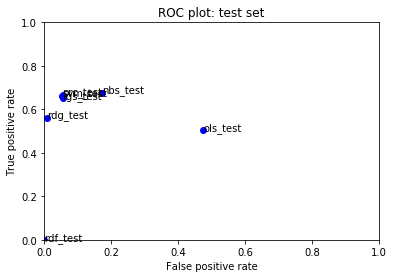

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='data/toxiccomments_train.csv', my_random_seed=70, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 8 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1     

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.48129046004599835


In [25]:
raw_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,word_count,punc_count
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,42,5
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,18,2
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,42,3
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,112,3
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13,1


In [26]:
my_submission.head()

,id,prediction
0,0000997932d777bf,True
1,000103f0d9cfb60f,False
2,000113f07ec002fd,True
3,0001b41b1c6bb37e,False
4,0001d958c54c6e35,True


In [27]:
my_submission.shape

(159571, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation